###### Analysis of Lepton Number Violation at 100 TeV   

This notebook documents my implementation of a random forest classifier which is used to optimize signal-background separation to maximize the statistical significance of discovery potential. I'll begin with a short explanation of the goal.   

We want to know what statistical significance we could expect to observe lepton number violation in a potential 100 TeV detector as a function of luminosity. This experiment will be essentially a counting experiment, so we can assume that the counts of both signal and background are poisson distributed, i.e., we assume the likelihood function below.

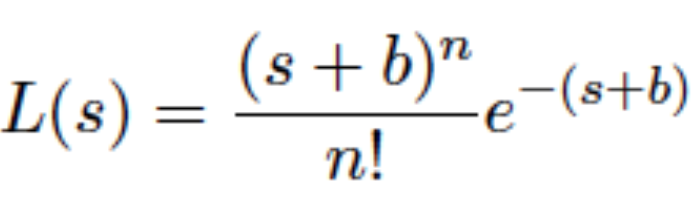

In [1]:
from IPython.display import Image
Image("img/poisson_likelihood.png")

To test for discovery, I'll use the log-likelihood ratio. We'll also ignore nuisance parameters (theta's) for now.

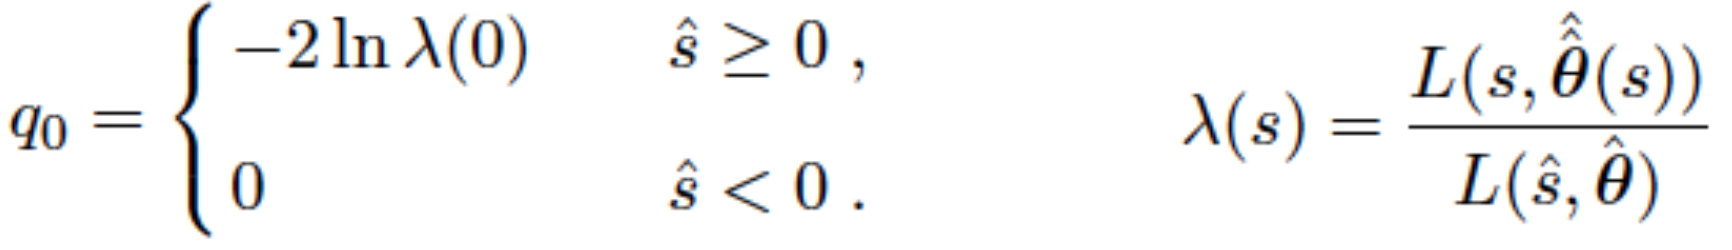

In [2]:
Image("img/likelihood_ratio.png")

The poisson significance for testing s=0 (background only hypothesis) is then given by the square root of the likelihood ratio which is just 

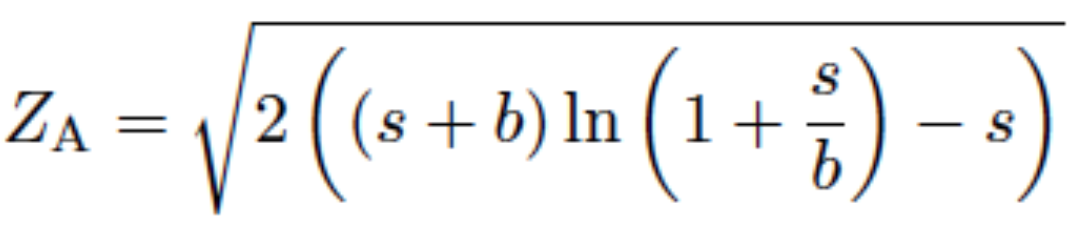

In [3]:
Image("img/poisson_significance.png")

In order to maximize this quantity, we can try to design a classifier which will learn to distinguish between signal and background, allowing us to perform a cut on some number of background events given that we can correctly identify them. Reducing the background in this way, will increase the level of expected significance (or discovery potential).   

For particle physics, the level of significance needed to fully reject the background-only hypothesis is Z = 5 so this is what we're hoping for if we want to reliably tell our experimental friends that the proposed experiment is worth all the funding and trouble because it has potential to discover lepton number violation.   

To get started, I'll import all the libraries I'll need for the analysis.

In [1]:
# Basic imports
from __future__ import division
import os

# Data analysis imports
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

# Visualization analysis imports
import matplotlib.pyplot as plt
from pandas.tools import plotting
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Contour, Figure, Layout
init_notebook_mode()

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn import grid_search
from sklearn.learning_curve import learning_curve

# Import cPickle for model persistence
import cPickle

# Import the wrangler class to generate visualizations of cross section probability densities.
from Wrangler import Wrangler

# Use rePYduce script to list software versions for reproducibility purposes
work_PATH = os.getcwd()
script_PATH = '/Users/pwinslow/DataScience/Projects/Quick_Scripts/'
os.chdir(script_PATH)
%run rePYduce.py numpy pandas matplotlib scikit-learn
os.chdir(work_PATH)

import warnings
warnings.filterwarnings('ignore')


General Information...
Author: Peter Winslow
Date: Wednesday January 04 2017

Python Information...
CPython: 2.7.12
IPython: 4.2.0

Module Information...
numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.17.1

System Information...
Compiler: GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)
System: Darwin
Release: 14.0.0
Machine: x86_64
Processor: i386
CPU Cores: 4
Interpreter: 64bit


Import full data set along with cross section and weight info and display event counts of the various backgrounds relative to the total. Also check the relative count of signal vs background events in full dataset.

In [2]:
Full_df = pd.read_csv('Data/Full_df.csv')
cs_df = pd.read_csv('Data/cross_section_and_weights_df.csv', index_col=0)

Tot_BG_events = sum(Full_df['Subclass'].value_counts().drop('Signal').values)
Tot_Signal_events = Full_df['Subclass'].value_counts()['Signal']

BG_Series = Full_df['Subclass'].value_counts().drop('Signal') / Tot_BG_events
BG_Signal_Series = Series([Tot_Signal_events, Tot_BG_events]
                          , index=['Signal', 'Background']) / (Tot_BG_events + Tot_Signal_events)

print 'Shares of total background\n'
for BG, count in BG_Series.iteritems():
    print 'Background: {0}\nPercentage of total background events: {1:0.0f}%'.format(BG, 100*count)    

print '\nShares of total event count\n'
for events, count in BG_Signal_Series.iteritems():
    print '{0}:\nPercentage of total events: {1:0.0f}%'.format(events, 100*count)

Shares of total background

Background: DiBoson WW
Percentage of total background events: 25%
Background: DiBoson ZZ
Percentage of total background events: 18%
Background: JetFake ttbar
Percentage of total background events: 12%
Background: JetFake Wjets
Percentage of total background events: 11%
Background: ChargeFlip Zy
Percentage of total background events: 10%
Background: DiBoson WZ
Percentage of total background events: 9%
Background: JetFake Single top
Percentage of total background events: 8%
Background: JetFake QCD
Percentage of total background events: 5%
Background: ChargeFlip ttbar
Percentage of total background events: 4%

Shares of total event count

Signal:
Percentage of total events: 16%
Background:
Percentage of total events: 84%


Take a peek at the actual dataframes

In [7]:
Full_df.head()

,electron number,positron number,jet Number,H_T(e),H_T(j),"Delta_R(L_e, NL_e)","Delta_R(L_j, NL_j)","Delta_R(L_e, L_j)","m(L_e, NL_e)","m(L_j, NL_j)",...,Sphericity_hadronic,Transverse_Sphericity_hadronic,Aplanarity_hadronic,Planarity_hadronic,Sphericity_global,Transverse_Sphericity_global,Aplanarity_global,Planarity_global,Class,Subclass
0,0.0,2.0,2.0,160.99,111.65,4.154311,1.345761,2.679569,481.521275,228.168977,...,0.069213,0.088304,2.525666e-17,0.046142,0.158238,0.186960,0.004375,0.099658,Background,DiBoson WW
1,0.0,2.0,2.0,207.38,181.14,4.779746,3.127819,2.480947,894.575590,151.806413,...,0.039081,0.050802,-8.392988e-17,0.026054,0.087673,0.094767,0.013158,0.040905,Background,DiBoson WW
2,0.0,2.0,7.0,144.67,1993.52,6.729532,4.718421,4.305147,1407.399061,5689.138311,...,0.031178,0.037504,2.517324e-03,0.017429,0.031925,0.037248,0.003464,0.016665,Background,DiBoson WW
3,0.0,2.0,2.0,201.77,547.06,1.836087,3.377107,2.693691,665.870725,1343.084695,...,0.064504,0.082533,-2.897073e-17,0.043003,0.124646,0.119300,0.029705,0.043491,Background,DiBoson WW
4,2.0,0.0,3.0,178.55,268.55,4.426139,2.066712,1.364678,2621.979947,4994.529329,...,0.000846,0.000801,2.448352e-04,0.000237,0.001521,0.001611,0.000312,0.000598,Background,DiBoson WW


In [8]:
cs_df

,DiBoson WW,DiBoson WZ,DiBoson ZZ,ChargeFlip Zy,ChargeFlip ttbar,JetFake ttbar,JetFake Wjets,JetFake Single top,JetFake QCD,Signal
cross section (pb),6.328211e-03,0.068516,5.791495e-03,1.400009,0.139625,0.038841,0.120157,1.351104e-03,0.264516,4.515693e-03
cross section weight (pb),9.991808e-08,0.000003,1.248975e-07,0.000057,0.000014,0.000001,0.000004,6.898316e-08,0.000022,9.476200e-08


Before moving forward, we'll just take a quick look for any null values

In [9]:
print 'Series of null values in each column:\n'
print Full_df.isnull().sum()
print '\nArray of row indices in which null values exist:'
pd.isnull(Full_df).any(1).nonzero()[0]

Series of null values in each column:

electron number                   0
positron number                   0
jet Number                        0
H_T(e)                            0
H_T(j)                            0
Delta_R(L_e, NL_e)                0
Delta_R(L_j, NL_j)                0
Delta_R(L_e, L_j)                 0
m(L_e, NL_e)                      1
m(L_j, NL_j)                      1
m(L_e, L_j)                       0
cos(L_e, NL_e)                    1
cos(L_j, NL_j)                    1
cos(L_e, L_j)                     0
MET                               0
Sphericity_leptonic               0
Transverse_Sphericity_leptonic    0
Aplanarity_leptonic               0
Planarity_leptonic                0
Sphericity_hadronic               0
Transverse_Sphericity_hadronic    0
Aplanarity_hadronic               0
Planarity_hadronic                0
Sphericity_global                 0
Transverse_Sphericity_global      0
Aplanarity_global                 0
Planarity_global         

array([255782])

It looks like there's only one row in the entire dataset which contains null values. I'm guessing that this was a precision issue in the Wrangler::Feature_Architect method that created the feature matrix... Either way, a single row isn't worth much of a fight so I'll just drop this one row and move on.

In [3]:
print Full_df.shape
Full_df.drop(Full_df.index[255782], inplace=True)
Full_df.index = range(Full_df.shape[0])
print Full_df.shape

(305105, 29)
(305104, 29)


Now let's take a look at the probability densities associated with each feature

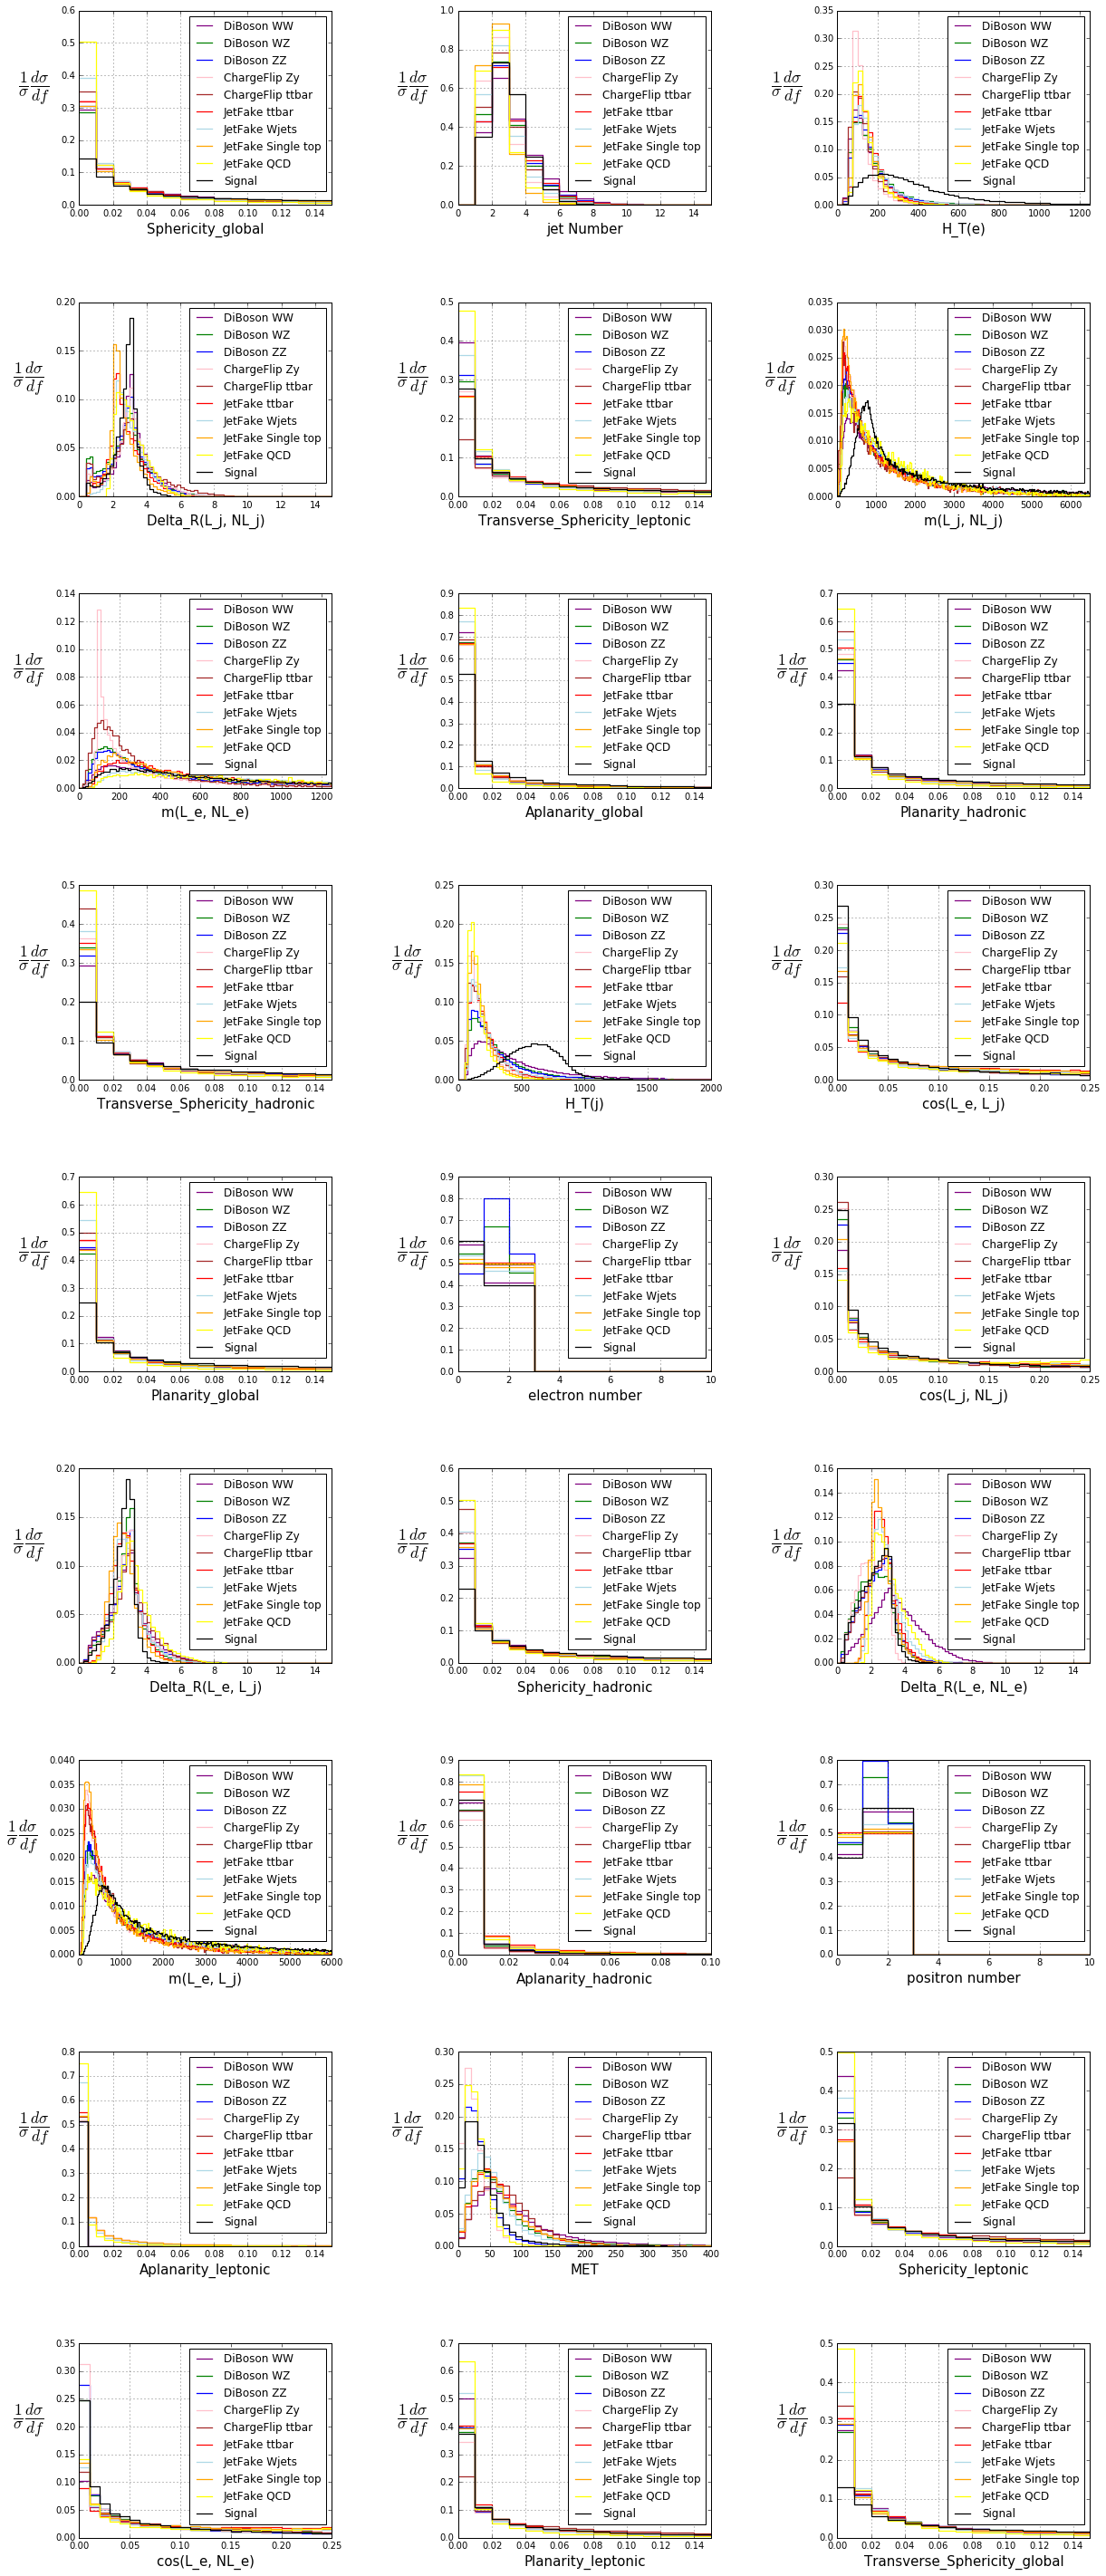

In [11]:
def HistoGrapher(df, feature_dict, grid=True, xlabelsize=None, ylabelsize=None, xrot=None, yrot=None, 
                 figsize=None, layout=None, **kwargs):
    
    if 'linewidth' not in kwargs:
        kwargs['linewidth'] = 1.25
        
    # Initiate a Wrangler class instance for plotting purposes
    Hist_Wrangler = Wrangler()

    # Define subplot structure
    fig, axes = plotting._subplots(naxes=len(feature_dict), 
                                   ax=None, 
                                   squeeze=False, 
                                   sharex=False, 
                                   sharey=False, 
                                   figsize=figsize, 
                                   layout=layout)
    _axes = plotting._flatten(axes)

    # Loop through feature_dict, extracting feature and plotting specs for each dictionary element
    for plot_num, dict_items in enumerate(feature_dict.items()):
        ax = _axes[plot_num]
        feature, hist_specs = dict_items
        first_bin, last_bin, step_size = hist_specs
        
        for label_cnt, label in enumerate(Subclass_labels):
            x, y = Hist_Wrangler.Hist_Constructor(df[df['Subclass'] == label], 
                                                  feature, 
                                                  cs_df.loc['cross section (pb)'][label], 
                                                  cs_df.loc['cross section weight (pb)'][label], 
                                                  first_bin, 
                                                  last_bin, 
                                                  step_size)
            ax.plot(x, y, color=color_list[label_cnt], label=label, **kwargs)
            
        ax.grid(grid)
        ax.set_xlim(first_bin, last_bin)
        ax.set_xlabel(feature, fontsize=15)
        ax.set_ylabel(r'$\frac{1}{\sigma} \frac{d \sigma}{d f }}$', fontsize=25, rotation=0, labelpad = 30)
        plotting._set_ticks_props(axes, xlabelsize=xlabelsize, xrot=xrot, ylabelsize=ylabelsize, yrot=yrot)
        ax.legend()
        fig.subplots_adjust(wspace=0.5, hspace=0.5)

        
# Choose some features and specs for plotting
feature_info = {'H_T(j)':(0,2000,25), 
                'H_T(e)':(0,1250,25), 
                'Delta_R(L_e, NL_e)':(0, 15, .2), 
                'Delta_R(L_j, NL_j)':(0,15,.2), 
                'Delta_R(L_e, L_j)':(0,15,.25), 
                'm(L_e, NL_e)':(0,1250,15),
                'cos(L_e, NL_e)':(0,.25,.01), 
                'cos(L_j, NL_j)':(0,.25,.01), 
                'cos(L_e, L_j)':(0,.25,.01),
                'electron number':(0,10,1), 
                'positron number':(0,10,1), 
                'jet Number':(0,15,1), 
                'MET':(0,400,10), 
                'Sphericity_leptonic':(0,.15,.01), 
                'm(L_j, NL_j)':(0,6500,25), 
                'm(L_e, L_j)':(0,6000,25), 
                'Transverse_Sphericity_leptonic':(0,.15,.01), 
                'Aplanarity_leptonic':(0,.15,.005), 
                'Planarity_leptonic':(0,.15,.01), 
                'Sphericity_hadronic':(0,.15,.01), 
                'Transverse_Sphericity_hadronic':(0,.15,.01), 
                'Aplanarity_hadronic':(0,.1,.01), 
                'Planarity_hadronic':(0,.15,.01), 
                'Sphericity_global':(0,.15,.01), 
                'Transverse_Sphericity_global':(0,.15,.01), 
                'Aplanarity_global':(0,.15,.01), 
                'Planarity_global':(0,.15,.01)}

# Plot
Subclass_labels = Series(Full_df['Subclass'].values.ravel()).unique()
color_list = ['purple', 'green', 'blue', 'pink', 'brown', 'red', 'lightblue','orange', 'yellow', 'black']
HistoGrapher(Full_df, feature_info, layout=(9,3), figsize=(20,50))

A brief glance at the visualizations above gives the sense that there are quite a few features that will be important in distinguishing signal from background.   

Before moving forward, I'll first perform the following feature engineering tasks:   
* Normalize all non-categorical features so that they all lie within the unit interval
* Translate categorical features (jet, electron, and positron number) to dummy variables

In [4]:
# Normalize all non-categorical features
dont_norm_list = ['jet Number', 'electron number', 'positron number']
features_to_be_normed = [x for x in Full_df.columns if x not in dont_norm_list][:-2]
Full_df[ features_to_be_normed ] = Full_df[ features_to_be_normed ].apply(lambda x: x / x.max(), axis=0)

# Generate dummy variables for jets
jet_dummies = pd.get_dummies(Full_df['jet Number'], prefix='Jet_Number:')
Full_df = pd.concat([jet_dummies, Full_df], axis=1)
Full_df.drop('jet Number', axis=1, inplace=True)

# Generate dummy variables for electrons
electron_dummies = pd.get_dummies(Full_df['electron number'], prefix='Electron_Number:')
Full_df = pd.concat([electron_dummies, Full_df], axis=1)
Full_df.drop('electron number', axis=1, inplace=True)

# Generate dummy variables for positrons
positron_dummies = pd.get_dummies(Full_df['positron number'], prefix='Positron_Number:')
Full_df = pd.concat([positron_dummies, Full_df], axis=1)
Full_df.drop('positron number', axis=1, inplace=True)

We now turn to the goal of training a random forest model to distinguish signal and background. Random forest models are less prone to overfitting than decision trees, as they are ensembles that average the results of each individual tree.    

To begin, I split the data into a development set and an evaluation set. We'll use the development set to both train the model and optimize the hyperparameters. Once hyperparameters have been chosen, the evaluation set gives an unbiased estimate of the optimized model's performance.   

It's important to recognize that there are many different backgrounds present in the data. To avoid selection bias when splitting the data, I use a stratified split to maintain the original proportional presence of each background in all of the resulting datasets.   

Finally, I'll take a random subset of 50,000 instances from the full dataset in order to speed up model selection for this demonstration.

In [5]:
# Convert full dataset to numpy ndarrays
all_inputs = Full_df[Full_df.columns[:-2]]
all_classes = Full_df[Full_df.columns[-1]]

# Select a random sample of 50,000 instances
X_keep, X_drop, Y_keep, Y_drop = train_test_split(all_inputs, 
                                                  all_classes, 
                                                  train_size = 50000, 
                                                  random_state = 23, 
                                                  stratify=all_classes)

# Split this reduced dataset into development and evaluation sets
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X_keep, 
                                                Y_keep, 
                                                test_size=0.33, 
                                                random_state=42, 
                                                stratify=Y_keep)

# Define a short method to reclassify signal (all backgrounds) as the '1' ('0') class
def reclass(Y):
    Y_new = np.copy(Y)
    Y_new[Y_new != 'Signal'] = 0
    Y_new[Y_new == 'Signal'] = 1
    Y_new = Y_new.astype(int)
    return Y_new

Before training a random forest classifier, I first perform feature selection which helps to reduce redundancy in the data, speeds up training, and reduces overfitting.

In [6]:
# Perform feature selection using a tree-based estimator. The threshold for selection is by default set to the mean
# of the importances.
clf = ExtraTreesClassifier(n_estimators=200)
_ = clf.fit(X_dev, Y_dev)
model = SelectFromModel(clf, prefit=True)
selected_Xdev = model.transform(X_dev)
selected_Xeval = model.transform(X_eval)

# Create a dataframe to map features to their importances
features = DataFrame()
features['feature'] = X_dev.columns
features['importance'] = clf.feature_importances_

# Print out important features
features[ features.importance > np.mean(features.importance) ].sort_values(by='importance', ascending=False)

,feature,importance
25,"Delta_R(L_e, NL_e)",0.056350
24,H_T(j),0.054329
34,MET,0.054182
37,Aplanarity_leptonic,0.051219
23,H_T(e),0.047360
31,"cos(L_e, NL_e)",0.044228
29,"m(L_j, NL_j)",0.036303
30,"m(L_e, L_j)",0.035776
28,"m(L_e, NL_e)",0.035763
26,"Delta_R(L_j, NL_j)",0.035364


When training your model and optimizing hyperparameters, it's customary to split your development dataset into a training and test set. The model is trained with the training set and hyperparameter optimization is done with the test set. However, the split may itself introduce bias.   

To control this possible bias effect, I implement a 5-fold cross validation, in which the development set is randomly split (in a stratified way) into 5 parts. For each of the 5 parts, the other 5-1 parts act as the training set while the 5th part acts as the test set. The average score of all iterations of this procedure is then take as the performance measure used to optimize the hyperparameters.

In [15]:
# Initialize a random forest classifier
rf = RandomForestClassifier()

# Define a parameter grid to search over
param_dist = {"n_estimators": [50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500], 
              "max_depth": [3, 5, 7, 9, 11], 
              'criterion': ['gini', 'entropy']}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(Y_dev, n_folds=10)

# Reclassify class vector
Y_dev = reclass(Y_dev)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 10
clf = grid_search.RandomizedSearchCV(rf, 
                                     param_distributions=param_dist, 
                                     n_iter=n_iter_search, 
                                     cv=cross_validation, 
                                     n_jobs=10, 
                                     verbose=10)
_ = clf.fit(selected_Xdev, Y_dev)

rf_best = clf.best_estimator_

# Pickle optimized random forest model for persistence
with open('LNV_rf_model.pkl', 'wb') as rf_model:
    cPickle.dump(rf_best, rf_model)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV] n_estimators=350, criterion=gini, max_depth=7 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=7, score=0.920417 - 1.7min
[CV] n_estimators=350, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=7, score=0.927121 - 1.7min
[C

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  1.7min


[CV]  n_estimators=350, criterion=gini, max_depth=7, score=0.924523 - 1.7min
[CV]  n_estimators=350, criterion=gini, max_depth=7, score=0.928955 - 1.7min
[CV] n_estimators=350, criterion=gini, max_depth=3 ...................
[CV] n_estimators=350, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=7, score=0.924455 - 1.7min
[CV] n_estimators=350, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=7, score=0.922640 - 1.7min
[CV] n_estimators=350, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=7, score=0.924134 - 1.7min
[CV] n_estimators=350, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.869449 - 1.0min
[CV] n_estimators=450, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.872055 - 1.0min
[CV]  n_estimators=350, criterion=g

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  2.7min


[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.866826 - 1.0min
[CV] n_estimators=450, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.867981 - 1.0min
[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.873955 - 1.0min
[CV] n_estimators=450, criterion=gini, max_depth=9 ...................
[CV] n_estimators=450, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.865890 - 1.0min
[CV] n_estimators=450, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.875149 - 1.0min
[CV]  n_estimators=350, criterion=gini, max_depth=3, score=0.867085 - 1.0min
[CV] n_estimators=450, criterion=gini, max_depth=9 ...................
[CV] n_estimators=450, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.922504 - 2.4min
[CV] n_estimators=250, criterion=gi

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  5.1min


[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.934069 - 2.4min
[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.937313 - 2.4min
[CV] n_estimators=250, criterion=gini, max_depth=7 ...................
[CV] n_estimators=250, criterion=gini, max_depth=7 ...................
[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.933990 - 2.4min
[CV] n_estimators=250, criterion=gini, max_depth=7 ...................
[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.932299 - 2.4min
[CV] n_estimators=250, criterion=gini, max_depth=7 ...................
[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.930705 - 2.4min
[CV] n_estimators=250, criterion=gini, max_depth=7 ...................
[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.931621 - 2.4min
[CV] n_estimators=250, criterion=gini, max_depth=7 ...................
[CV]  n_estimators=450, criterion=gini, max_depth=9, score=0.935484 - 2.4min
[CV] n_estimators=250, criterion=gi

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  5.1min


[CV]  n_estimators=250, criterion=gini, max_depth=7, score=0.919821 - 1.1min
[CV] n_estimators=500, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=7, score=0.930149 - 1.1min
[CV] n_estimators=500, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=7, score=0.928721 - 1.1min
[CV] n_estimators=500, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=7, score=0.926247 - 1.1min
[CV] n_estimators=500, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=7, score=0.922434 - 1.1min
[CV] n_estimators=500, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=7, score=0.924134 - 1.1min
[CV] n_estimators=500, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=250, criterion=gini, max_depth=7, score=0.921446 - 1.1min
[CV] n_estimators=500, criterion=gi

[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  8.7min


[CV]  n_estimators=500, criterion=gini, max_depth=9, score=0.932001 - 2.5min
[CV] n_estimators=50, criterion=gini, max_depth=11 ...................
[CV]  n_estimators=500, criterion=gini, max_depth=9, score=0.933771 - 2.5min
[CV]  n_estimators=500, criterion=gini, max_depth=9, score=0.933114 - 2.5min
[CV] n_estimators=50, criterion=gini, max_depth=11 ...................
[CV] n_estimators=50, criterion=gini, max_depth=11 ...................
[CV]  n_estimators=500, criterion=gini, max_depth=9, score=0.938209 - 2.5min
[CV] n_estimators=50, criterion=gini, max_depth=11 ...................
[CV]  n_estimators=500, criterion=gini, max_depth=9, score=0.933990 - 2.5min
[CV] n_estimators=50, criterion=gini, max_depth=11 ...................
[CV]  n_estimators=500, criterion=gini, max_depth=9, score=0.933692 - 2.5min
[CV] n_estimators=50, criterion=gini, max_depth=11 ...................
[CV]  n_estimators=500, criterion=gini, max_depth=9, score=0.928614 - 2.5min
[CV] n_estimators=50, criterion=gin

[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  9.0min


[CV] n_estimators=100, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=50, criterion=gini, max_depth=11, score=0.929809 -  17.1s
[CV]  n_estimators=50, criterion=gini, max_depth=11, score=0.933114 -  17.2s
[CV] n_estimators=100, criterion=entropy, max_depth=7 ................
[CV] n_estimators=100, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=50, criterion=gini, max_depth=11, score=0.934886 -  17.2s
[CV] n_estimators=100, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=50, criterion=gini, max_depth=11, score=0.935185 -  17.3s
[CV] n_estimators=100, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=50, criterion=gini, max_depth=11, score=0.933692 -  17.1s
[CV] n_estimators=100, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=50, criterion=gini, max_depth=11, score=0.936977 -  16.9s
[CV] n_estimators=100, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=100, criterion=entropy

[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  9.6min


[CV]  n_estimators=100, criterion=entropy, max_depth=7, score=0.919952 -  33.4s
[CV] n_estimators=400, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=7, score=0.919056 -  33.1s
[CV] n_estimators=400, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=7, score=0.919654 -  33.1s
[CV] n_estimators=400, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=7, score=0.922043 -  33.4s
[CV] n_estimators=400, criterion=gini, max_depth=9 ...................
[CV]  n_estimators=400, criterion=gini, max_depth=9, score=0.932896 - 1.9min
[CV] n_estimators=300, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=400, criterion=gini, max_depth=9, score=0.923100 - 1.9min
[CV] n_estimators=300, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=400, criterion=gini, max_depth=9, score=0.937910 - 1.9min
[CV]  n_estimators=400,

[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 11.5min


[CV]  n_estimators=400, criterion=gini, max_depth=9, score=0.933990 - 1.9min
[CV] n_estimators=300, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=400, criterion=gini, max_depth=9, score=0.929510 - 1.9min
[CV] n_estimators=300, criterion=entropy, max_depth=7 ................
[CV]  n_estimators=300, criterion=entropy, max_depth=7, score=0.915052 - 1.6min
[CV] n_estimators=350, criterion=entropy, max_depth=11 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=7, score=0.924843 - 1.6min
[CV] n_estimators=350, criterion=entropy, max_depth=11 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=7, score=0.919976 - 1.6min
[CV] n_estimators=350, criterion=entropy, max_depth=11 ...............
[CV]  n_estimators=300, criterion=entropy, max_depth=7, score=0.926269 - 1.6min
[CV]  n_estimators=300, criterion=entropy, max_depth=7, score=0.921446 - 1.6min
[CV] n_estimators=350, criterion=entropy, max_depth=11 ...............
[CV] n_estimators=35

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 15.5min finished


Using the best estimator from the random grid search above, I now present a classification report and a ROC curve using the evaluation set.

             precision    recall  f1-score   support

 background       0.95      0.97      0.96     13923
     signal       0.82      0.72      0.77      2577

avg / total       0.93      0.93      0.93     16500

Area under ROC curve: 0.848


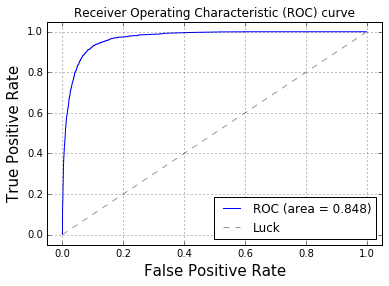

In [7]:
# Load pickled random forest model
with open('LNV_rf_model.pkl', 'rb') as rf_model:
    rf_loaded = cPickle.load(rf_model)
    
Y_predicted = rf_loaded.predict(selected_Xeval)
Y_eval = reclass(Y_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print classification_report(Y_eval, 
                            Y_predicted,
                            target_names=["background", "signal"])
print "Area under ROC curve: {:0.3f}".format(roc_auc)

# Compute ROC curve and area under the curve
rf_probs = rf_loaded.predict_proba(selected_Xeval)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_eval, rf_probs)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) curve', fontsize=12)
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

Metric definitions:   
* precision: Percentage of positive predictions that were correct   
* recall: Percentage of positive cases that the algorithm correctly predicted   
* f1-score (harmonic mean of precision and recall): 2 * (precision * recall) / (precision + recall)   

The statistical significance will be mainly aided by being able to reject backgrounds rather than identify signal. Thus, the fact that above report indicates my classifier has higher accuracy for identification of backgrounds is reassuring.   

The final task is to plot the decision scores of our random forest classifier for both the signal and the background. The background (signal) is in blue (red) and, if perfectly classified as such, will be 0 (1). By optimizing the cut on the decision score for which the signal counts overtake the background counts we achieve the maximum signal-background separation.    

This cut then allows us to maximize the signal cross section (S) relative to the background cross section (B), obtaining the maximal statistical significance for discovery potential which is given by sqrt(2 (S+B) log(1 + S/B) - 2 S).

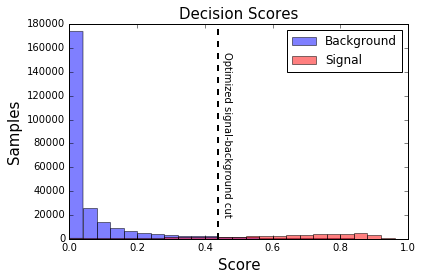

In [8]:
plot_colors = "br"
plot_step = 0.02
class_names = ('Background', 'Signal')

# Plot the two-class decision scores
selected_inputs = model.transform(all_inputs)
twoclass_output = rf_loaded.predict_proba(selected_inputs)[:, 1]
plot_range = (0, 1)
cnts_list = []
for i, n, c in zip(range(2), class_names, plot_colors):
    cnts, bins, bars = plt.hist(twoclass_output[reclass(all_classes) == i], 
                                bins=25, 
                                range=plot_range, 
                                facecolor=c, label='%s' % n, 
                                alpha=.5)
    cnts_list.append(cnts)

# Calculate the optimized cut on the decision score which maximizes statistical significance
cut = bins[ cnts_list[0] < cnts_list[1] ][0]

plt.legend(loc='upper right')
plt.axvline(x=cut, ymin=0, ymax=2e+5, linewidth=2, color='black', linestyle='dashed')
plt.text(cut+0.01, 1.5e+5, 'Optimized signal-background cut', rotation=-90, fontsize=10)
plt.ylabel('Samples', fontsize=15)
plt.xlabel('Score', fontsize=15)
plt.title('Decision Scores', fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

The final step in this analysis is to calculate the expected signal and background counts given the above cut. To do this, we first calculate the total signal and background cross sections. These are the probability of a signal/background event occurring per beam flux per beam focus. By multiplying these quantities by a variable representing luminosity, S and B become counts and we can then determine what amount of luminosity the experimentalists must design the experiment to operate at in order to observe lepton number violation at significance Z.

In [9]:
weight_map = {}
for bg in cs_df.columns:
    weight_map[bg] = cs_df[bg]['cross section weight (pb)']    
    
df = pd.concat([Series(all_classes), Series(twoclass_output)], axis=1)
df.columns = ['Subclass', 'Decision_Score']
df['weight'] = df.Subclass.map(weight_map)
df['Class'] = df.Subclass.map(lambda x: 'Background' if x != 'Signal' else 'Signal')
df = df[['Class', 'Subclass', 'weight', 'Decision_Score']]
cut_df = df[ df.Decision_Score >= cut ]

B = cut_df[ cut_df.Class == 'Background' ].weight.sum()
S = cut_df[ cut_df.Class == 'Signal' ].weight.sum()
g_best = (0.17693 / 0.202)**8
g_worst = (0.210 / 0.202)**8
Z = 1e+3 * np.sqrt(2 * (S + B) * np.log(1 + S / B) - 2 * S)
Z_best = 1e+3 * np.sqrt(2 * (g_best * S + B) * np.log(1 + g_best * S / B) - 2 * g_best * S)
Z_worst = 1e+3 * np.sqrt(2 * (g_worst * S + B) * np.log(1 + g_worst * S / B) - 2 * g_worst * S)


# Design discovery potential plot

x = np.linspace(0, 25, 100)
region_color = 'rgb(244, 197, 66)'
text_color = 'rgb(244, 150, 66)'

lower = Scatter(
            x = list(x),
            y = list( np.sqrt(x) * Z_worst),
            name = 'lowerlimit',
            fill = None,
            mode = 'lines',
            showlegend = False,
            line=dict( 
                        color=region_color,
                        dash = 'dot'
                    )
          )
upper = Scatter(
            x = list(x),
            y = list( np.sqrt(x) * Z_best),
            name = 'upperlimit',
            fill = 'tonexty',
            mode = 'lines',
            showlegend = False,
            line=dict( 
                        color=region_color,
                        dash = 'dot'
                    )
          )

layout = Layout(
                title="e<sup>&plusmn;</sup>e<sup>&plusmn;</sup>+di-jet discovery potential at 100 TeV",
                titlefont=dict(family='Courier New, monospace',
                               size=20,
                               color='black'
                             ),
                xaxis=dict(title='L (ab<sup>-1</sup>)',
                           titlefont=dict(family='Georgia',
                                          size=18,
                                          color='black'
                                        )
                        ),
                yaxis=dict(title='Z',
                           titlefont=dict(family='Georgia',
                                          size=20,
                                          color='black'
                                        )
                        ),
                width=650,
                height=500,
    
                annotations=[
                        dict(
                                x=15,
                                y=30,
                                text='M<sub>0</sub>=-1.99',
                                showarrow=False,
                                textangle=-7.5,
                                font=dict(
                                                family='sans serif',
                                                size=20,
                                                color=text_color
                                            )
                            ),
                        dict(
                                x=12,
                                y=70,
                                text='M<sub>0</sub>=-1',
                                showarrow=False,
                                textangle=-20,
                                font=dict(
                                                family='sans serif',
                                                size=20,
                                                color=text_color
                                            )
                            )
                            
        
                            ]
                )

data = [lower, upper]
fig = Figure(data=data, layout=layout)
iplot(fig)

This is our final insight! The level of luminosity required for discovery of same-sign lepton number violation at the proposed 100 TeV collider is well within reach of projected reach (around 25-50 ab^{-1} over full life-time).

In [35]:
scan_data = pd.read_csv('Data/100TeV_Results.csv', header=None)
scan_data.columns = ['Run', 'mass', 'coupling', 'sigma', 'weight', 'Z']
scan_data.head()

,Run,mass,coupling,sigma,weight,Z
0,1,250.0,0.2,0.098014,2.784740e-05,4.093486
1,2,500.0,0.2,0.030945,6.551981e-06,1.965183
2,3,750.0,0.2,0.011286,2.390907e-06,1.074035
3,4,1000.0,0.2,0.005033,1.104164e-06,0.655775
4,5,1250.0,0.2,0.002561,5.886579e-07,0.349331


In [36]:
def discovery_lines(df, Lumi):
    
    x = df.mass.unique()
    y = df.coupling.unique()
    X, Y = np.meshgrid(x, y)
    Z = X*0

    def z(m, y):
        return df[ (df.mass == m) & (df.coupling == y) ].Z.values[0]

    for i in range(len(X[:,0])):
        for j in range(len(Y[0,:])):
            Z[i,j] = np.sqrt(Lumi) * z( X[i,j], Y[i,j] )

    contours = plt.contour(x, y, Z, [5])
    plt.xlim(250, 2500)
    plt.ylim(0,1)
    plt.close()
    path = contours.collections[0].get_paths()[0]
    verts = path.vertices

    return verts, Z

In [46]:
T_GeCurr = 3e+25; T_GeNextGen = 2e+28; GF_TeV = 11.66; LambdaH = 2.74e-3; GoV = 1/40.9; Mo = 2;

def c_limit(T_Ge, Mo, m):
    fac1 = ( (9/2) * (1/.092)**2 * (1/T_Ge) * (1/LambdaH)**4 * (1/GoV) * (1/Mo)**2 )**(1/2)
    fac2 = 2 * 2 * GF_TeV**2
    return ( fac1 * fac2 * m**5 )**(1/4)

x = np.linspace(0, 5, 100)
c_curr_lower = c_limit(T_GeCurr, 4, x)
c_curr_upper = c_limit(T_GeCurr, 1, x)
curr_unc_color = 'rgb(66, 225, 100)'
curr_top_color = 'rgb(66, 275, 194)'
c_nextgen_lower = c_limit(T_GeNextGen, 4, x)
c_nextgen_upper = c_limit(T_GeNextGen, 1, x)
nextgen_unc_color = 'rgb(244, 223, 66)'
nextgen_top_color = 'rgb(244, 175, 66)'

verts_1, Z_1 = discovery_lines(scan_data, 1)
verts_10, Z_10 = discovery_lines(scan_data, 10)
verts_100, Z_100 = discovery_lines(scan_data, 100)


discovery_1fb = Scatter(
            x = 1e-3 * verts_1[:,0],
            y = verts_1[:,1],
            name = "L = 1fb<sup>-1</sup>",
            fill = None,
            mode = 'lines',
            line = dict(
                        color = 'black',
                        width = 3,
                        shape = 'spline'
                    )
        )
discovery_10fb = Scatter(
            x = 1e-3 * verts_10[:,0],
            y = verts_10[:,1],
            name = "L = 10fb<sup>-1</sup>",
            fill = None,
            mode = 'lines',
            line = dict(
                        color = 'black',
                        width = 3,
                        dash = 'dash',
                        shape = 'spline'
                    )
        )
discovery_100fb = Scatter(
            x = 1e-3 * verts_100[:,0],
            y = verts_100[:,1],
            name = "L = 100fb<sup>-1</sup>",
            fill = None,
            mode = 'lines',
            line = dict(
                        color = 'black',
                        width = 3,
                        dash = 'dot',
                        shape = 'spline'
                    )
        )

nextgen_lower = Scatter(
            x = list(x),
            y = list(c_nextgen_lower),
            name = 'nextgen_lowerlimit',
            fill = None,
            mode = 'lines',
            showlegend = False,
            line=dict( 
                        color=nextgen_top_color
                    )
          )
nextgen_upper = Scatter(
            x = list(x),
            y = list(c_nextgen_upper),
            name = 'nextgen_upperlimit',
            fill = 'tonexty',
            mode = 'lines',
            showlegend = False,
            line=dict( 
                        color=nextgen_top_color
                    )
          )
curr_lower = Scatter(
            x = list(x),
            y = list(c_curr_lower),
            name = 'current_lowerlimit',
            fill = 'tonexty',
            mode = 'lines',
            showlegend = False,
            line=dict( 
                        color=nextgen_unc_color
                    )
          )
curr_upper = Scatter(
            x = list(x),
            y = list(c_curr_upper),
            name = 'current_upperlimit',
            fill = 'tonexty',
            mode = 'lines',
            showlegend = False,
            line=dict( 
                        color=curr_unc_color
                    )
          )
curr_top = Scatter(
            x = list(x),
            y = [1.75 for z in range(100)],
            name = 'current_top',
            fill = 'tonexty',
            mode = 'lines',
            showlegend = False,
            line=dict(
                        color=curr_top_color
                    )

        )


layout = Layout(
                title="e<sup>&plusmn;</sup>e<sup>&plusmn;</sup>+di-jet discovery potential at 100 TeV",
                titlefont=dict(family='Courier New, monospace',
                               size=20,
                               color='black'
                             ),
                xaxis=dict(title='M (TeV)',
                           titlefont=dict(family='Georgia',
                                          size=18,
                                          color='black'
                                        )
                        ),
                yaxis=dict(title='y<sub>eff</sub>',
                           titlefont=dict(family='Georgia',
                                          size=20,
                                          color='black'
                                        )
                        ),
                showlegend=True,
                width=700,
                height=500,
                
                annotations=[
                        dict(
                                x=4.5,
                                y=.685,
                                text='1 Tonne',
                                showarrow=False,
                                textangle=-15,
                                font=dict(
                                                family='sans serif',
                                                size=25,
                                                color='rgb(244, 175, 75)'
                                            )
                            ),
                        dict(
                                x=2.75,
                                y=.85,
                                text='GERDA',
                                showarrow=False,
                                textangle=-30,
                                font=dict(
                                                family='sans serif',
                                                size=25,
                                                color='rgb(66, 225, 119)'
                                            )
                            )
                            
        
                            ]
                )

data = [nextgen_lower, nextgen_upper, curr_lower, curr_upper, curr_top, 
        discovery_1fb, discovery_10fb, discovery_100fb]
fig = Figure(data=data, layout=layout)
iplot(fig)